In [1]:
import os
import warnings
from typing import TypedDict, Annotated

warnings.filterwarnings("ignore")

from IPython.display import Markdown




from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    AIMessage,
    SystemMessage
)
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig

from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


from langchain_community.vectorstores.pgvector import PGVector

# from langchain_postgres import PGVector


from tqdm import tqdm


from typing_extensions import TypedDict
from langgraph.graph import StateGraph,add_messages,START,END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain.messages import RemoveMessage # to delete something from state permenantly
from langchain.messages import HumanMessage

from typing import TypedDict, Annotated

from langgraph.graph.message import add_messages


from langchain_core.documents import Document
from langchain_community.document_loaders import DirectoryLoader

from dotenv import load_dotenv
load_dotenv(dotenv_path=r"C:\Users\hasee\Desktop\Legal Chatbot\.env")

True

In [2]:
CONNECTION_STRING = os.environ.get("CONNECTION_STRING","")
SUPERBASE_SERVICE_ROLE_KEY = os.environ.get("SUPERBASE_SERVICE_ROLE_KEY","")
SUPABASE_URL = os.environ.get("SUPABASE_URL","")

In [ ]:
# from sqlalchemy import create_engine
# from sqlalchemy.pool import NullPool  

# engine = create_engine(
#     CONNECTION_STRING,
#     poolclass = NullPool  
#     )
# with engine.connect() as conn:
#     print("Connected to Supabase Postgres")

Connected to Supabase Postgres


In [3]:
from supabase import create_client

supabase_client = create_client(SUPABASE_URL,SUPERBASE_SERVICE_ROLE_KEY)
print("Succefully coonectd to Supabase client")

Succefully coonectd to Supabase client


In [4]:
# chatting llm
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
#embedding llm
EMBEDDING = OpenAIEmbeddings(model="text-embedding-3-small")

# State & System Prompt

In [6]:
class AgentState(TypedDict):
    documents_path:str
    documents:list[Document]
    chunks:list[Document] 
    collection_name:str
    retrieved_docs:list[Document]
    context: str 
    answer:str
    messages: Annotated[list[BaseMessage], add_messages]
    doc_id:str
    summary:str
    vectorstore_uploaded:bool
    rewritten_query:str




PROMPT_TEMPLATE = """
        You are an expert Legal AI Assistant for Pakistan. Your task is to answer legal questions based strictly on the provided context.

        Instructions:
        1. Source-Based Answering: Answer the question using ONLY the information provided in the Context below. Do not use outside knowledge.
        2. Specific Legal Citations: When making a statement, you must cite the specific legal authority found in the text (e.g., "Article 6 of the Constitution", "Section 302 of PPC", "Clause 3"). 
        3. Citation Format: Format citations as: [Legal Reference]** (Found in: Chunk ID/Source).
            Example: "Every citizen has the right to a fair trial as per Article 10-A (Source: Chunk 2, constitution.pdf).."
        4. No Hallucinations:** If the provided context does not contain the answer, state: "The provided context does not contain sufficient information to answer this question."

        Context:
        {context}

        Question:
        {question}

        Answer:
        """


# Document ID generator

In [8]:
import hashlib
def get_file_hash(file_path: str) -> str:
    """
    It reads a file (like a PDF) and generates a SHA-256 hash,
      which is a fixed-length unique string representing the file’s content.

    If:
    The file content is exactly the same → hash is the same
    Even 1 byte changes → hash is completely different
    """
    hasher = hashlib.sha256()
    with open(file_path, "rb") as f:
        hasher.update(f.read())
    return hasher.hexdigest()

# get_file_hash() reads the entire file content and produces a SHA-256 hash.
# SHA-256 guarantees:
# Same content → same hash → same doc_id
# Even 1 byte difference → completely different hash
# So if a user uploads the same PDF file again, the hash will be identical → same doc_id.


# Even one single byte change in the file will produce a completely different hash.
# That means if you change one word in the PDF, the doc_id will be different, because the file content is no longer exactly the same.

# Check If PDF already exist

In [7]:
def set_doc_id(state:AgentState):
    if not os.path.isdir(state["documents"]):
        raise ValueError("Directoy uploaded not supported with hashing yet")
    state["doc_id"] = get_file_hash(state["documents_path"])
    return state


def check_pdf_already_uploaded(state:AgentState):
    """Checkif PDF already exist in SUpbase"""
    response = (supabase_client.table("documents").select("doc_id").eq("doc_id",state["doc_id"]).limit(1).execute())
    if response.data:
        print("Pdf already exist in supbase skipping documnet ingesion...")
        state["vectorstore_uploaded"] = True
    else:
        state["vectorstore_uploaded"] = False
    return state

# Document Loader

In [9]:
def document_loader(state: AgentState):
    path = os.path.abspath(state["documents_path"])  # ensure absolute
    if os.path.isfile(path):  # single PDF case
        loader = PyPDFLoader(path)
        documents = loader.load()
        # add meta data as langchain preserve it
        for doc in documents:
            doc.metadata["doc_id"] = state["doc_id"]

    elif os.path.isdir(path):  # directory case
        loader = DirectoryLoader(
            path=path,
            glob="*.pdf",
            loader_cls=PyPDFLoader)
        documents = loader.load()
        for doc in documents:
            doc.metadata["doc_id"] = state["doc_id"]
    else:
        raise ValueError(f"Invalid documents_path: {path}")
    state["documents"] = documents
    return state

# Text Splitter

In [10]:
def text_splitter(state:AgentState):
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
    chunks = splitter.split_documents(state["documents"])

    rows = [] # for supbase bulk insert
    # add metadata
    for i,chunk in enumerate(chunks):
        source_path = chunk.metadata.get("source","")
        file_name = os.path.basename(source_path) if source_path else "unknow.pdf"

        metadata = {
            "doc_id":state["doc_id"],
            "chunk_index":i,
            "file_name":file_name,
            "page":chunk.metadata.get("page")  
        }
        # update langchian chunk metadata usd by pgvector
        chunk.metadata.update(metadata)

        # prepare complete data(metadata) to be pushed to supabase 
        rows.append({
            "doc_id":state["doc_id"],
            "chunk_index":i,
            "file_name":file_name,
            "page":chunk.metadata.get("page"),
            "content":chunk.page_content
        })

    if rows:
        # Insert in Supbase in Bulk
        supabase_client.table("documents").insert(rows).execute()

    print(f"Total chunks to upload: {len(chunks)}")
    state["chunks"] = chunks
    return state

# Create Vector Store

``PGVector = LangChain-controlled table``  
``Manual insert = Your-controlled table``

In [11]:
def create_vector_store(state: AgentState, batch_size: int = 50):

    if state.get("vectorstore_uploaded"):
        print("Skipping vectostore creation PDF already exist")
        return state
    
    vectorstore = PGVector(
        connection_string=CONNECTION_STRING,
        collection_name=state["collection_name"],
        embedding_function=EMBEDDING,
        use_jsonb=True,
    )

    chunks = state["chunks"]
    for i in tqdm(range(0, len(chunks), batch_size), desc="Uploading chunks"):
        batch = chunks[i:i + batch_size]
        vectorstore.add_documents(batch)

    state["vectorstore_uploaded"] = True
    print(f"Uploaded {len(chunks)} chunks to PGVector")        
    return state

# Query Rewriter For Previous context 

In [12]:
def query_rewriter(state: AgentState):
    """Rewrite follow-up questions to be standalone using conversation context"""
    
    human_messages = [m for m in state.get("messages", []) if isinstance(m, HumanMessage)]
    current_query = human_messages[-1].content
    
    # If there's conversation history, rewrite the query
    if len(state.get("messages", [])) > 1:
        
        # Build conversation context
        memory_text = state.get("summary") or ""
        if not memory_text:
            conversation_history = []
            for m in state.get("messages", [])[:-1]:  # Exclude current question
                role = "User" if isinstance(m, HumanMessage) else "Assistant"
                conversation_history.append(f"{role}: {m.content}")
            memory_text = "\n".join(conversation_history)
        
        # Rewrite query to be standalone
        rewrite_prompt = f"""Given this conversation history:
            {memory_text}

            Rewrite the following question to be standalone (include necessary context from history):
            Question: {current_query}

            Standalone question:"""
                    
        response = llm.invoke([HumanMessage(content=rewrite_prompt)])
        rewritten_query = response.content.strip()
        
        print(f"Original: {current_query}")
        print(f"Rewritten: {rewritten_query}")
        
        # Store rewritten query for retrieval
        state["rewritten_query"] = rewritten_query
    else:
        state["rewritten_query"] = current_query
    
    return state


# Retriever

In [13]:
# We can add Metadata filtering Here
# We can add Metadata filtering Here
def retriever(state: AgentState):     
    vectorstore = PGVector(
        connection_string=CONNECTION_STRING,
        collection_name=state["collection_name"],
        embedding_function=EMBEDDING,
        use_jsonb=True
    )

    retriever = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={
            "k": 5,
            "filter": {"doc_id": state["doc_id"]}
        }
    )
    
    # Use rewritten query instead of original
    query = state.get("rewritten_query", state["messages"][-1].content)
    
    retrieved_docs = retriever.invoke(query)

    state["retrieved_docs"] = retrieved_docs
    return state


# COntext Builder for LLM

In [14]:
# file_name is added during text splitting
# page exists → PyPDFLoader adds this automatically
def context_builder(state:AgentState):
        retrieved_docs = state.get("retrieved_docs",[])
        if not state["retrieved_docs"]:
            state["context"] = ""
            state["answer"] = ("I could not find relevant information in the provided document.")
        else:

            context = "\n\n".join(
                f"[Source: {doc.metadata.get('file_name', 'Unknown')} "
                f"- Page {doc.metadata.get('page', 'N/A')}]\n"    # page no
                f"{doc.page_content}"
                for doc in retrieved_docs
            )
            state["context"] = context
        return state

# Weather to create Summary(Memory) or Not

In [15]:
def summary_creation(state:AgentState):
    existing_summary = state["summary"] # we first load existing summary

    # We have two scenrio:
    # 1. We might already have summary
    # 2. or We are Genrating summary fir the first time
    if existing_summary:
        prompt = (
            f"Existing summary:\n{existing_summary}\n\n"
            "Extend the summary using new conversation above"
        )
    else:
        prompt = "summarize the conversation above"

    message_for_summary = state["messages"] + [HumanMessage(content=prompt)]

    print("Callin summary LLM") # debugging
    # generate summary
    response = llm.invoke(message_for_summary)

    # now delete the orignal messages that have been summarized
    message_to_delete = state["messages"][:-2] if len(state["messages"]) > 2 else []

    return {
        "summary":response.content,
        "messages":[RemoveMessage(id=m.id) for m in message_to_delete]
    }

# SUmmarize the Chat or Not

In [16]:
def should_summzarizer(state:AgentState):
    return len(state["messages"]) > 6

# Agent

In [17]:
# cat node with memory
def agent_response(state: AgentState):
    """
    Generates the LLM response for the current query, injecting memory (summary or previous messages)
    and RAG context into the prompt.
    """
    context = state.get("context", "")

    # Get all human messages
    human_messages = [m for m in state.get("messages", []) if isinstance(m, HumanMessage)]
    if not human_messages:
        raise ValueError("No human message found in state for retrieval")

    query = human_messages[-1].content

    prompt_messages = []

    # Memory injection 
    # Use summary if it exists, otherwise include all previous messages
    memory_text = state.get("summary", "")
    if not memory_text:
        conversation_history = []
        for m in state.get("messages", []):
            role = "User" if isinstance(m, HumanMessage) else "Assistant"
            conversation_history.append(f"{role}: {m.content}")
        memory_text = "\n".join(conversation_history) if conversation_history else "No previous conversation."

    # Inject memory as system message
    prompt_messages.append(SystemMessage(content=f"Conversation Memory:\n{memory_text}"))

    # RAG context + current query 
    formatted_prompt = PROMPT_TEMPLATE.format(
        context=context,
        question=query
    )
    prompt_messages.append(HumanMessage(content=formatted_prompt))

    print("Calling Agent Response LLM")  # debugging
    response = llm.invoke(prompt_messages)

    # Save AI response in state
    state["messages"].append(AIMessage(content=response.content))
    state["answer"] = response.content

    return state


# Conditonal(weather ingestion or asking from Predefined vectorstore)

In [18]:
def conditional(state: AgentState):
    """Route based on whether we're creating new vectorstore or using existing one"""
    # Only create vectorstore if:
    if state.get("documents_path") and not state.get("vectorstore_uploaded", False):
        return "create_vectorstore"
    
    # Use existing vectorstore if vectorstore_name is provided
    else:
        return "retriever"

In [14]:
# from langgraph.checkpoint.postgres import PostgresSaver
# import psycopg

# conn = psycopg.connect(
#     CONNECTION_STRING,
#     autocommit=True
# )
# # PostgresSaver --> LangGraph will automatically create its own tables in your Supabase Postgres database the first time it runs.
# checkpointer = PostgresSaver(conn) 
# # It creates the internal tables in Supabase:
# # checkpoints
# # checkpoint_writes
# # These tables store:
# # AgentState snapshots
# # Messages
# # Node execution progress
# # Thread state
# checkpointer.setup()


# Graph

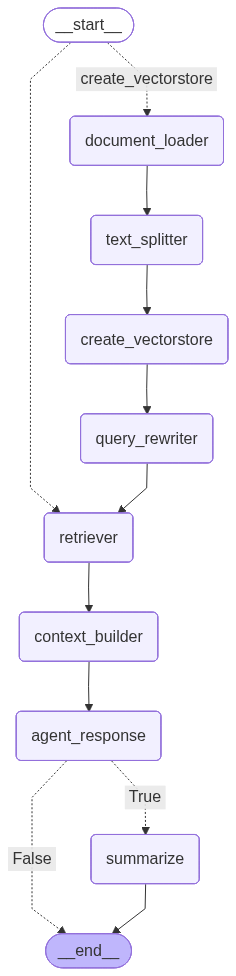

In [22]:
from langgraph.checkpoint.postgres import PostgresSaver

workflow = StateGraph(AgentState)
# nodes
workflow.add_node("document_loader",document_loader)
workflow.add_node("text_splitter", text_splitter)
workflow.add_node("create_vectorstore", create_vector_store)
workflow.add_node("query_rewriter", query_rewriter)
workflow.add_node("retriever", retriever)
workflow.add_node("context_builder", context_builder)
workflow.add_node("agent_response", agent_response)
workflow.add_node("summarize", summary_creation)

# edges
workflow.add_conditional_edges(
    START,
    conditional,
    {
        "create_vectorstore": "document_loader",
        "retriever": "retriever"  # Add this route
    }
)

# if new vector store path
workflow.add_edge("document_loader", "text_splitter")
workflow.add_edge("text_splitter", "create_vectorstore")
workflow.add_edge("create_vectorstore", "query_rewriter")


workflow.add_edge("query_rewriter", "retriever")
workflow.add_edge("retriever", "context_builder")
workflow.add_edge("context_builder", "agent_response")

workflow.add_conditional_edges(
    "agent_response",
    should_summzarizer,
    {
        True: "summarize",
        False: END
    }
)
workflow.add_edge("summarize", END)



app = workflow.compile()
app

doc_id ==> it is useful as it aassign unique no to each document and especially useful wehn we are metadatafiltering on the basis of doc_id in case of multiples PDFs.

In [23]:
file_path = "../data/Constitution and law/PAKISTAN PENAL CODE.pdf"
doc_id = get_file_hash(file_path) # get doc id using the hash funciton
collection_name =(os.path.splitext(os.path.basename(file_path))[0].lower().replace(" ", "_"))
thread_id = "user-123"

# Scenerio 1: Upload new PDFs

In [24]:
with PostgresSaver.from_conn_string(CONNECTION_STRING) as checkpointer:
    checkpointer.setup()
    graph = workflow.compile(checkpointer=checkpointer)
    config = {"configurable": {"thread_id": thread_id}}

    initial_state = {
        "documents_path": file_path,  # pdf path --> document loader --> pipline it will take
        "doc_id": doc_id,
        "collection_name": collection_name,
        "messages": [HumanMessage(content="What is punishment for making false claim in court?")],
        "summary": ""
    }

    result = graph.invoke(initial_state, config=config)
    print("Answer 1:", result["answer"])
    

C:\Users\hasee\AppData\Local\Temp\ipykernel_40280\3055916066.py:4: LangChainPendingDeprecationWarning: This class is pending deprecation and may be removed in a future version. You can swap to using the `PGVector` implementation in `langchain_postgres`. Please read the guidelines in the doc-string of this class to follow prior to migrating as there are some differences between the implementations. See <https://github.com/langchain-ai/langchain-postgres> for details about the new implementation.
  vectorstore = PGVector(


Calling Agent Response LLM
Callin summary LLM
Answer 1: The punishment for making a false claim in court, as per Section 209 of the Pakistan Penal Code, includes imprisonment of either description for a term which may extend to two years and the possibility of a fine [Section 209 of PPC]** (Found in: PAKISTAN PENAL CODE.pdf - Page 75).


# Scenerio 2: use Existing Vectorstore

In [25]:
from langgraph.checkpoint.postgres import PostgresSaver

file_path = "../data/Constitution and law/PAKISTAN PENAL CODE.pdf"
doc_id = get_file_hash(file_path) # get doc id using the hash funciton
collection_name = (os.path.splitext(os.path.basename(file_path))[0].lower().replace(" ", "_"))
# SAME thread_id to maintain memory
thread_id = "user-123"

with PostgresSaver.from_conn_string(CONNECTION_STRING) as checkpointer:
    # checkpointer.setup()
    graph = workflow.compile(checkpointer=checkpointer)
    config = {"configurable": {"thread_id": thread_id}}  # Same thread!

    initial_state = {
        "doc_id": doc_id,
        "collection_name": collection_name,  # Use existing vectorstore
        "messages": [HumanMessage(content="What is the penalty for that?")],  # Follow-up question
    }

    result = graph.invoke(initial_state, config=config)
    print("Answer 2:", result["answer"])

Calling Agent Response LLM
Answer 2: The penalty for making a false claim in court, as per Section 209 of the Pakistan Penal Code, includes imprisonment for up to two years and the possibility of a fine. [Section 209 of PPC]** (Found in: PAKISTAN PENAL CODE.pdf - Page 75).


# Scenerio 3: Test memory with context quesion

In [26]:
# Continue same conversation

with PostgresSaver.from_conn_string(CONNECTION_STRING) as checkpointer:
    # checkpointer.setup()
    graph = workflow.compile(checkpointer=checkpointer)
    config = {"configurable": {"thread_id": thread_id}}  # Same thread

    initial_state = {
        "doc_id": doc_id,
        "vectorstore_name": collection_name,
        "messages": [HumanMessage(content="Is there any exception to this rule?")],  # Requires context from previous answers
    }

    result = graph.invoke(initial_state, config=config)
    print("Answer 3:", result["answer"])

Calling Agent Response LLM
Answer 3: The provided context does not contain sufficient information to answer this question.
